# Night Averaging the Photometry
---

Some of the poor fits we get seem to be driven (or at least contributed to) by multiple samples on some epochs. To combat this, implement night-averaging. This should _probably_ be done by default anyway. Will test out on `iPTF13bvn` to check

In [1]:
%matplotlib notebook
from imp import reload  # Python 3.0 - 3.3
       
from matplotlib import pyplot as plt
from matplotlib import rc
# rc('text', usetex=True)

import os
import numpy as np
from astropy.table import Table

import pycoco as pcc

In [ ]:
snname = "iPTF13bvn"

sn = pcc.classes.SNClass(snname)
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path, "lc/"+ snname + ".dat"))
sn.load_list(os.path.join(pcc.defaults._default_list_dir_path, snname + ".list"))

sn.load_spec()
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))
sn.check_overlaps()

sn.plot_lc(xextent=60, showsnname=True)


As can be seen in the above figure, the fit is poor, and there is a large amount of scatter around t=56470

In [ ]:
dt = sn.phot.data["SDSS_i"]

In [ ]:
dt["Night"] = list(map(lambda x: np.round(x), dt["MJD"]))

In [ ]:
dt.add_index("Night")

In [ ]:
dt_grouped = dt.group_by("Night")

In [ ]:
for key, group in zip(dt_grouped.groups.keys, dt_grouped.groups):
    print(key)
    print(group)
    print('')

In [ ]:
dt_grouped["weights"] = 1.0/((dt_grouped["flux_err"])*(dt_grouped["flux_err"]))
dt_grouped    

In [ ]:
from astropy.table import Table, Column, Row

na_table = Table(names = ("MJD","flux","flux_err","filter"),
                dtype = (dt["MJD"].dtype,dt["flux"].dtype,dt["flux_err"].dtype,dt["filter"].dtype))
for i, col in enumerate(na_table.columns):
#     print(i, col)
    na_table[col].unit = dt[col].unit
    
for group in dt_grouped.groups:
    wmean = np.average(group["flux"], weights=group["weights"])
    wmean_err = np.sqrt(1./np.sum(1./(group["flux_err"]*group["flux_err"])))
    print(np.mean(group["MJD"]), wmean, wmean_err)
    na_table.add_row((np.mean(group["MJD"]), wmean, wmean_err, "SDSS_i"))

In [ ]:
for i, col in enumerate(na_table.columns):
#     print(i, col)
    na_table[col].unit = dt[col].unit

In [ ]:
na_table

In [ ]:
sn.load_phot(phot_table=na_table)

In [ ]:
sn.plot_lc()

## Using Class Method
___


In [2]:
snname = "iPTF13bvn"

sn = pcc.classes.SNClass(snname)
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path, "lc/"+ snname + ".dat"))
sn.load_list(os.path.join(pcc.defaults._default_list_dir_path, snname + ".list"))

sn.load_spec()
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))
sn.check_overlaps()

sn.plot_lc(xextent=60, showsnname=True)

In [3]:
len(sn.phot.phot)

222

In [4]:
sn.phot.nightaverage(verbose=True)

0 {'_masked': False, '_column_class': <class 'astropy.table.column.Column'>, 'columns': <TableColumns names=('MJD','flux','flux_err','filter')>, '_meta': OrderedDict(), 'formatter': <astropy.table.pprint.TableFormatter object at 0x112ef32b0>, '_copy_indices': True, '_init_indices': True, 'primary_key': None}
0 MJD
1 flux
2 flux_err
3 filter
56460.8755 5.07127252889e-16 6.61000375805e-18
56462.1226667 6.60564991248e-16 8.41506952952e-18
56463.065 8.85205493006e-16 1.15739674672e-17
56465.1586667 1.63785001914e-15 1.34556963053e-17
56466.2526667 1.91815649601e-15 4.88242014697e-17
56468.094 2.71644e-15 2.50193e-17
56469.145 2.93531685459e-15 1.91218937112e-17
56470.9905 3.30868109635e-15 2.15541389313e-17
56472.203 3.46725793076e-15 2.25814435168e-17
56474.12 3.5156e-15 6.47598e-17
56475.23 3.54813e-15 3.26795e-17
56477.18 3.35738e-15 6.18451e-17
56478.21 3.14775e-15 5.79837e-17
56484.27 1.59221e-15 1.46648e-17
56485.22 1.34896e-15 1.24244e-17
56487.25 9.50605e-16 8.75539e-18
56494.18 5.

<IPython.core.display.Javascript object>


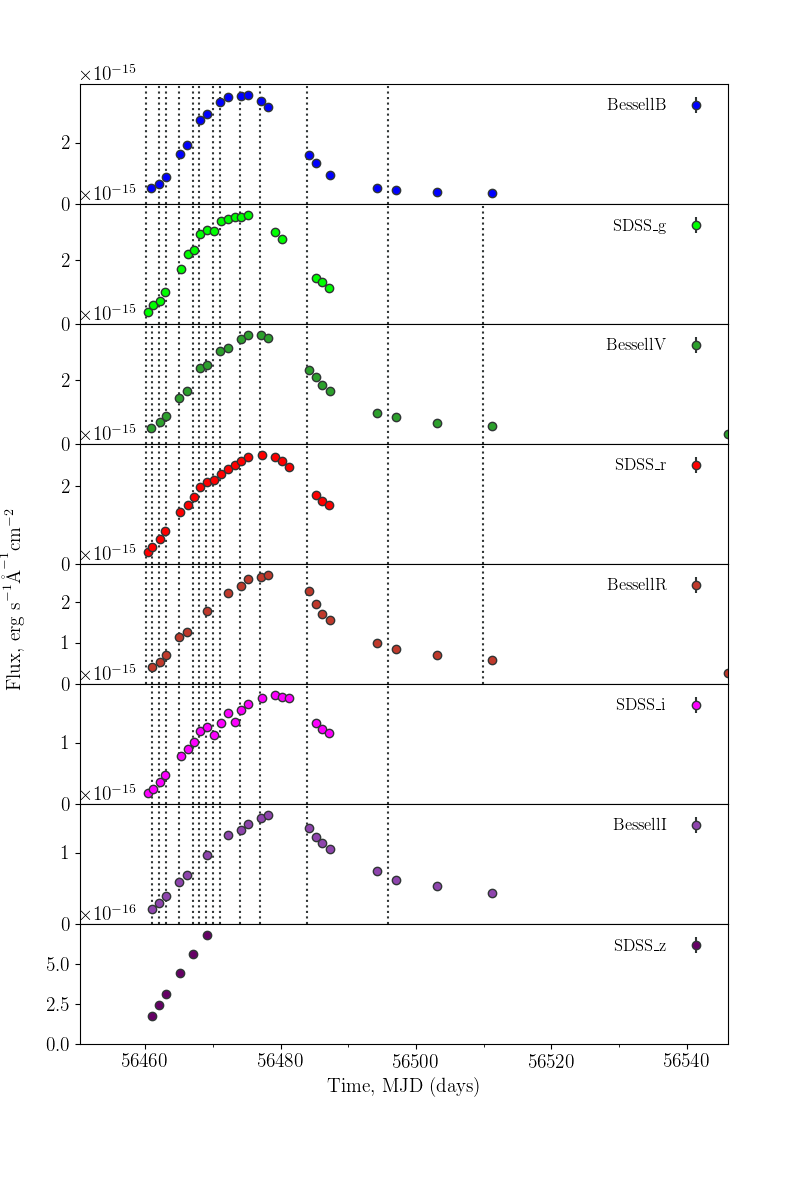

In [5]:
sn.plot_lc(fit=False)

In [6]:
len(sn.phot.phot)

151

['BessellB',
 'SDSS_g',
 'BessellV',
 'SDSS_r',
 'BessellR',
 'SDSS_i',
 'BessellI',
 'SDSS_z']

In [14]:
sn.phot._phot_format_for_save(filters = sn.phot.data.keys)

MJD,flux,flux_err,filter
d,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),
float64,float64,float64,str8


In [8]:
sn.phot.save(filename=snname+".dat", path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"),
                  format="ascii.fast_commented_header", squash=True, verbose = True, sort = False)

has data
/Users/berto/Code/CoCo/data/lc_na/iPTF13bvn.dat
Overwriting /Users/berto/Code/CoCo/data/lc_na/iPTF13bvn.dat
MJD          flux                 flux_err        filter
 d  erg / (Angstrom cm2 s) erg / (Angstrom cm2 s)       
--- ---------------------- ---------------------- ------


In [ ]:
# filter_name = "SDSS_i"
filter_names = ["SDSS_i", "SDSS_z"]
for filter_name in filter_names:
    if not os.path.exists(os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+filter_name)):
        os.mkdir(os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+filter_name))
    sn.phot.save(filename=snname+".dat", path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+filter_name),
                      filters = filter_name, format="ascii.fast_commented_header", squash=True)

In [ ]:
sn.phot._phot_format_for_save()

## Inspect New Fit
____


In [ ]:
pcc.coco.run_LCfit(path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/SDSS_i/"+snname+".dat"), model="Bazin09")
# pcc.coco.run_LCfit(path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+snname+".dat"), model="Kessler10")
# pcc.coco.run_LCfit(path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+snname+".dat"), model="Karpenka12")

In [ ]:
snname = "iPTF13bvn"

sn = pcc.classes.SNClass(snname)
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+ snname + ".dat"))
# sn.load_list(os.path.join(pcc.defaults._default_list_dir_path, snname + ".list"))

# sn.load_spec()
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))
sn.check_overlaps()

sn.plot_lc(xextent=60, showsnname=True)

In [ ]:
sn.phot.phot

In [ ]:
refit = False
if refit:
    pcc.coco.run_LCfit(path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/SDSS_z/"+snname+".dat"), model="Karpenka12")
    pcc.coco.run_LCfit(path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/SDSS_i/"+snname+".dat"), model="Kessler10")

In [ ]:
snname = "iPTF13bvn"

sn = pcc.classes.SNClass(snname)
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+ snname + ".dat"))
# sn.load_list(os.path.join(pcc.defaults._default_list_dir_path, snname + ".list"))

# sn.load_spec()
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))
sn.check_overlaps()

sn.plot_lc(xextent=60, showsnname=True)

In [ ]:
## EACH FIT WRITES TO SNNAME.RECON EACH TIME. NEED TO MAKE TEMP AND MERGE - DO IT IN SNCLASS LCFIT THEN DUMP TO RECON?

In [ ]:
sn.phot.phot

## Night Average All SNe
----


In [ ]:
phot_dir = pcc.defaults._default_data_dir_path+"lc"
ignore_list = ["README"]

for phot_filename in os.listdir(phot_dir):
    if phot_filename not in ignore_list and phot_filename[0] != ".":
        snname = phot_filename.replace(".dat", "")
        sn = pcc.classes.SNClass(snname)
        sn.load_phot( path = os.path.join(phot_dir, phot_filename))
        print(snname, phot_filename, len(sn.phot.phot), end=" ")
        sn.phot.nightaverage(verbose = False)
        print(len(sn.phot.phot))
        sn.phot.save(filename=snname+".dat", path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"),
                  format="ascii.fast_commented_header", squash=True)

In [ ]:
    sn.phot.save(filename=snname+".dat", path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+filter_name),
                      filters = filter_name, format="ascii.fast_commented_header", squash=True)